In [1]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
from matplotlib import pyplot as plt 
from scipy import interpolate
import cartopy
import warnings; warnings.simplefilter('ignore')
from numba import jit

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, AdvectionRK4_3D, ErrorCode
import math
from datetime import timedelta
from operator import attrgetter


%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)

plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False



plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38623 Dashboard: http://127.0.0.1:43457/status,Cluster Workers: 9 Cores: 72 Memory: 134.72 GB


In [2]:
def getCoeff(windstress,t,s):
    
    # define coeffs for Schmidt no
    sca1 = 2073.1
    sca2 = -125.62
    sca3 =    3.6276
    sca4 =   -0.043219
    
    SchmidtNoDIC = sca1 + sca2*t + sca3*t*t + sca4*t*t*t
    
    
    atmrho=1.2;
    recip_sqrtRhoA = 1/np.sqrt(atmrho);

    ustar = np.sqrt(windstress)*recip_sqrtRhoA;

    ustofu11 =  0.381800;
    u11 =  11 ;
    clindrag_1  =  0.000065;
    clindrag_2  =  0.000490;
    cquadrag_1  = clindrag_1/u11/2;
    cquadrag_2  = clindrag_1*u11/2 + clindrag_2;
 
 #if ( ustar .LT. ustofu11 )
    tmp1 = -cquadrag_2/cquadrag_1*0.5;
    tmp2 = np.sqrt(tmp1*tmp1 + ustar*ustar/cquadrag_1);
    wind = np.sqrt(tmp1 + tmp2);
    
    
    #print(np.array(wind[:,0]))
    #calculate piston velocity
    pisvel=0.337*wind**2/3.6e5
    
    # not sure if this goes here or if we need it              pCO2sat(i,j) = AtmosP(i,j,bi,bj)*AtmospCO2(i,j,bi,bj)

# then account for Schmidt number
    Kwexch = pisvel/(np.sqrt(SchmidtNoDIC/660))
    
    tk = 273.15 + t
    tk100 = tk/100
    tk1002=tk100*tk100

    P1atm = 1.01325 # bars
    Rgas = 83.1451 # bar*cm3/(mol*K)
    RT = Rgas*tk
    delta = (57.7  - 0.118*tk)
    B1 = -1636.75 + 12.0408*tk - 0.0327957*tk*tk
    B = B1 + 3.16528 *tk*tk*tk*(0.00001)
    
    fugf = np.exp( (B+2*delta) * (P1atm/RT))

          
    ff = np.exp(-162.8301 + 218.2968/tk100  +   90.9241*np.log(tk100) - 1.47696 *tk1002 +
               s * (.025695  - .025225*tk100 +  0.0049867*tk1002))

    ak0 = np.exp(93.4517/tk100 - 60.2409 +  23.3585 * np.log(tk100) +
            s * (0.023517 - 0.023656*tk100 +  0.0047036*tk1002))
            

    return ff, fugf, ak0, Kwexch

#def Coeff_vec(a, b, c):
    # apply ufunc wrapper
 #   return xr.apply_ufunc()


def FluxCO2(wind, t, s, pCO2):
    ff, fugf, ak0, Kwexch = getCoeff(wind,t,s)
    
    Flx = Kwexch*(ff*278e-6 -  pCO2*fugf*ak0)*1024.5 ##  should be multiply, have checked multiple times

    
    return Flx

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False

#run = 'layers0.15'


plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

#for x in run:
    ## read in data #######
      
#data_dir_m = '/glade/scratch/myoungs/'+run_m
data_dir = '/glade/p/univ/umit0025/newcarbon/dop_15'

print(data_dir)
    

#iters2 = range(72112464,72164880,144)
#dsmean = open_mdsdataset(data_dir,prefix=['DIAG','DIAGLayer','DIAGSurf'],delta_t=600,iters = iters1)
ds = open_mdsdataset(data_dir,prefix=['DIAG','DIAGTracer','DIAGSurf'],delta_t=600)#,iters=iters2)


#ds =  open_mdsdataset(data_dir,prefix=['DIAGLayer','DIAG'],delta_t=600)
#                        # ignore_unknown_vars==True)#,iters='377225') # ,'DIAGTracer'
grid = xgcm.Grid(ds, periodic=['X'])
#gridmean = xgcm.Grid(dsmean, periodic=['X'])
ds

/glade/p/univ/umit0025/newcarbon/dop_15


AttributeError: module 'xarray' has no attribute 'auto_combine'

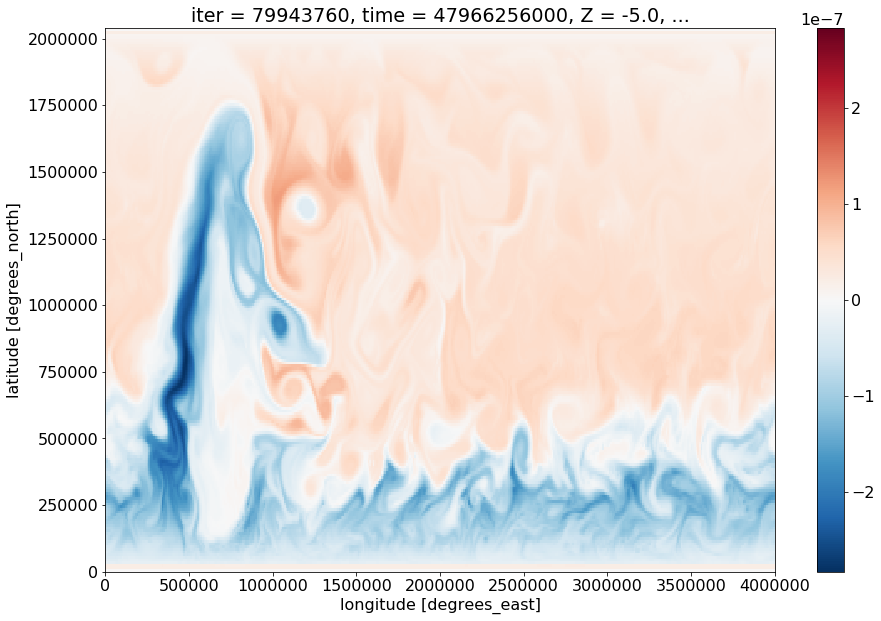

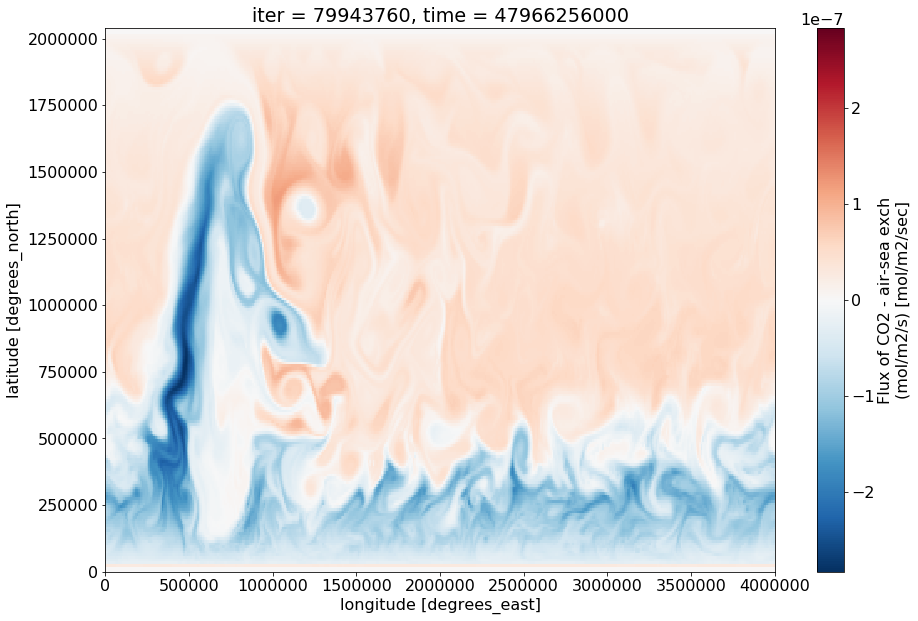

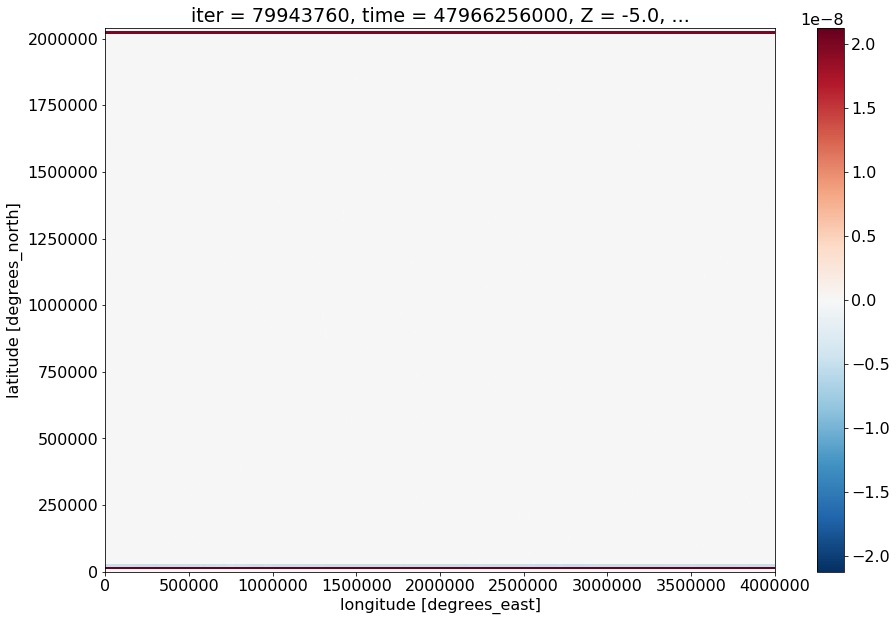

In [4]:
Flux = FluxCO2(grid.interp(ds.oceTAUX[-1],'X'),ds.THETA[-1,0],35,ds.DICPCO2[-1])

plt.figure()
(Flux).plot()

plt.figure()
ds.DICCFLX[-1].plot()


plt.figure()
(Flux - ds.DICCFLX[-1]).plot()

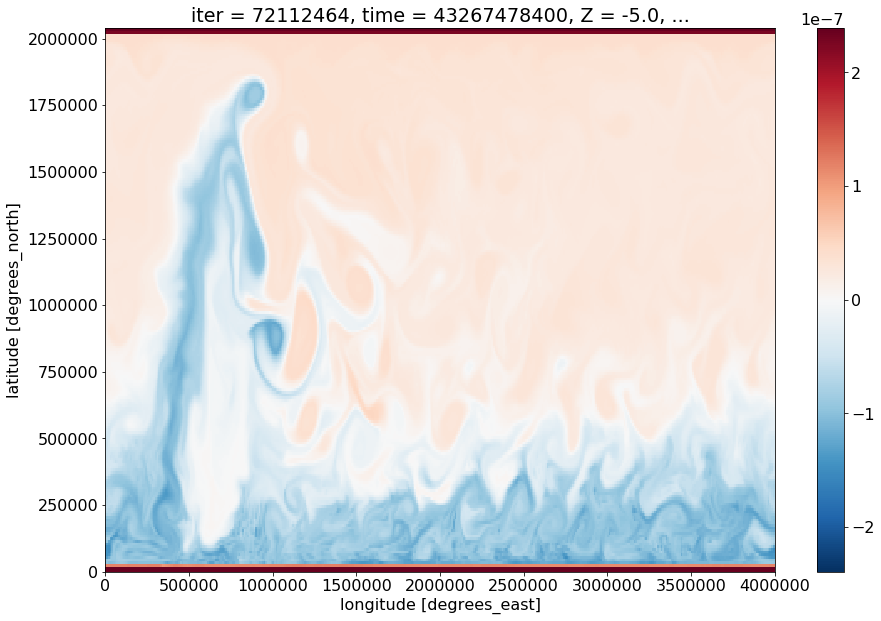

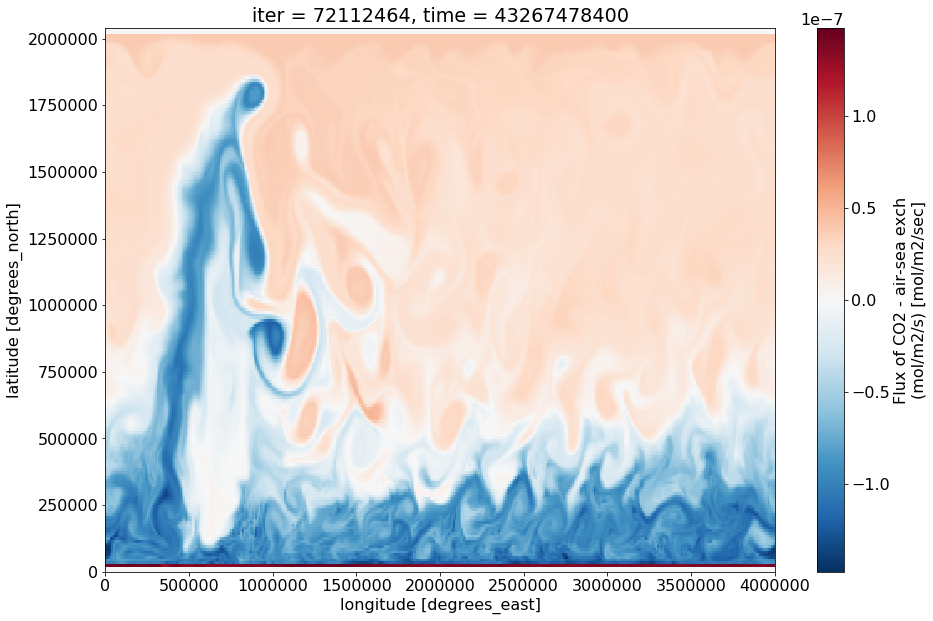

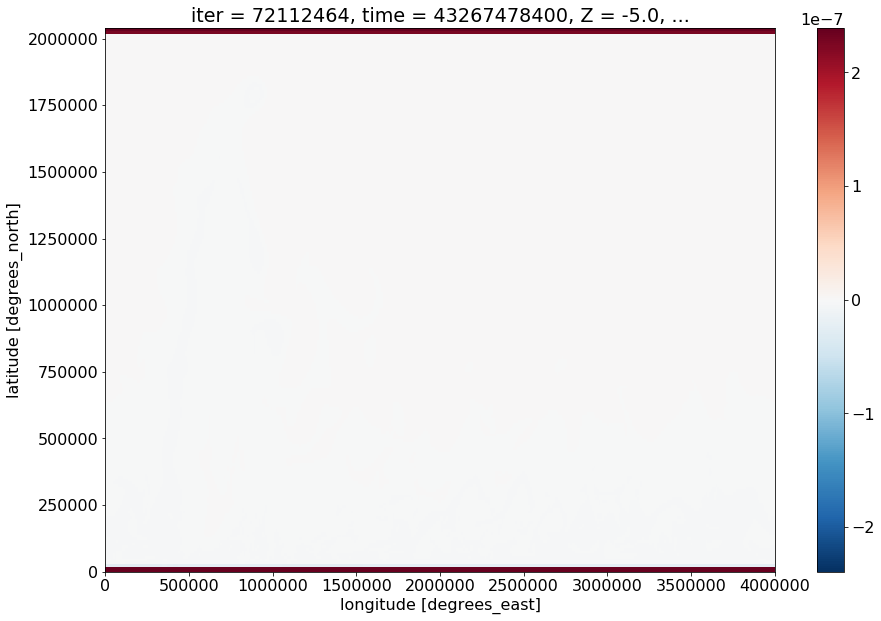

In [50]:
plt.figure()
(2800*Flux).plot()

plt.figure()
ds.DICCFLX[0].plot()


plt.figure()
(2800*Flux - ds.DICCFLX[0]).plot()